Exploring the output files generated by the Salish Sea Atlantis Model
for the BC Parks Living Labs Project - preliminary runs

Scenarios
- control
- heatwave (2023 summer for 10 days)
- climate change (+2oC warming by 2050)

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [2]:

species_of_interest = { #benthic, 1 depth
    'macroalgae':'Macroalgae', 'seagrass':'Seagrass', 'bivalves':'Bivalves',
}

## scenario files

In [3]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/control_01/outputSalishSea.nc"
heatwave_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/heatwave_01/outputSalishSea.nc"
climate_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/climate_01/outputSalishSea.nc"

control = xr.open_dataset(str(control_file), decode_cf=True)
heatwave = xr.open_dataset(str(heatwave_file), decode_cf=True)
climate = xr.open_dataset(str(climate_file), decode_cf=True)

t = np.ma.filled(control.variables['t'], np.nan)

In [4]:
# Masking based on temperature

Temps = np.ma.filled(control.Temp[1,:,5], np.nonzero)
(ocean_boxes) = Temps.nonzero()
ocean_boxes = ocean_boxes[0]
ocean_boxes = ocean_boxes[1:ocean_boxes.size-1]
ocean_boxes

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,
        15,  16,  18,  19,  20,  21,  23,  26,  28,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  54,  55,  57,  58,  60,  62,  63,
        64,  66,  68,  72,  73,  74,  75,  79,  80,  81,  82,  83,  84,
        85,  86,  88,  90,  91,  92,  94,  96,  98, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124])

## Group plotting functions

In [6]:
# Plot variables
label_size = 11
font_size = 12
line_width = 2

def plot_benthic_box(group, scenario, box_number): # benthos, shellfish

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('Percent (%) change')
    ax.set_title('Biomass of benthic groups across all boxes in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim(y_min, y_max)

    for species in group:
        benthic_oiled = scenario.variables[group[species] + '_N'][start:end,box_number] # tonnes
        benthic_control = control.variables[group[species] + '_N'][start:end,box_number]
        ratio = (benthic_oiled / benthic_control-1)*100
        control_ratio = (benthic_control / benthic_control-1)*100
        ax.plot(time, ratio, '.')
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k', linewidth = 2)

def plot_bacteria_box(scenario, box_number): #bacteria, plankton

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    # ax.set_ylim([y_min, y_max])

    for species in groups.bacteria:
        if "pelagic" in species:
            bact_oiled = np.ma.filled(scenario.variables[groups.bacteria[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes, take only water column layers
            bact_control = np.ma.filled(control.variables[groups.bacteria[species] + '_N'][start:end,box_number,0:5], np.nan)
            b_oiled = bact_oiled.sum(axis=1)
            b_control = bact_control.sum(axis=1)
        else:
            b_oiled = np.ma.filled(scenario.variables[groups.bacteria[species] + '_N'][start:end,box_number,6], np.nan) # tonnes, take only sediment layer
            b_control = np.ma.filled(control.variables[groups.bacteria[species] + '_N'][start:end,box_number,6], np.nan)
        
        ratio = b_oiled / b_control
        control_ratio = b_control / b_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(groups.bacteria, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_pelagic_box(group, scenario, box_number): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of pelagic groups in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
    #ax.set_ylim([0.99, 1.01])

    for species in group:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        ratio = p_oiled / p_control
        control_ratio = p_control / p_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_sediment_box(group, scenario, box_number): #mostly for sediment_feeders

    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario:control')
    ax.set_title('Biomass of groups in sediment in Salish Sea Atlantis', fontsize = font_size)
    #ax.set_ylim([y_min, y_max])

    for species in group:
        s_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,6], np.nan) # tonnes
        s_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,6], np.nan)
        ratio = s_oiled / s_control
        control_ratio = s_control / s_control
        ax.plot(time, ratio, linewidth = 2)
    
    ax.legend(group, loc='center left')
    ax.plot(time, control_ratio, 'k',linewidth = 2)

def plot_pelagic_biomass_box(group, scenario, box_number):

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])
        
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,0:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

def plot_benthic_biomass_box(group, scenario, box_number): 

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])
        
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number], np.nan)
        p_oiled = pelagic_oiled
        p_control = pelagic_control
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

def plot_sediment_biomass_box(group, scenario, box_number): 

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])
        
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,6], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,6], np.nan)
        p_oiled = pelagic_oiled
        p_control = pelagic_control
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

def plot_surface_biomass_box(group, scenario, box_number): # benthos, shellfish

    for species in group:
        fig, ax = plt.subplots(figsize = (14,3))
        ax.tick_params(labelsize=label_size)
        ax.set_ylabel('mg N/m^3')
        ax.set_title('Biomass of ' + str(group[species]) + ' in Salish Sea Atlantis box ' + str(box_number), fontsize = font_size)
        #ax.set_ylim([y_min, y_max])

        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,box_number,4:5], np.nan) # tonnes
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,box_number,4:5], np.nan)
        p_oiled = pelagic_oiled.sum(axis=1)
        p_control = pelagic_control.sum(axis=1)
        p_max = p_oiled.max()
        p_min = p_oiled.min()
        ax.plot(time, p_oiled, linewidth = 2)
        ax.plot(time, p_control, 'k',linewidth = 2)

## heatwaves

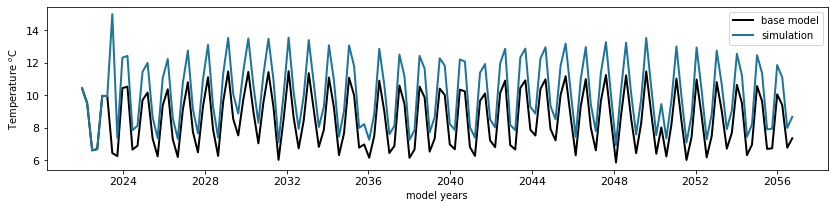

In [17]:
# Temperature at all depths - heatwave_01

start = 0 #after burn-in. Model start 2007 (112 if model start is 1992)
end = t.size-1

time = t[start:end]

fig, ax = plt.subplots(figsize = (14,3))
ax.tick_params(labelsize=label_size)

Temp_control = np.ma.filled(control.Temp[start:end,ocean_boxes,5], np.nonzero)
t1_control = Temp_control.mean(axis=1)
#t1_control = t1_control.mean(axis=1)

Temp_heatwave = np.ma.filled(heatwave.Temp[start:end,ocean_boxes,5], np.nonzero)
t1_heatwave = Temp_heatwave.mean(axis=1)
#t1_heatwave = t1_heatwave.mean(axis=1)

ax.plot(time, t1_control, 'k', linewidth = 2);
ax.plot(time, t1_heatwave, '#1e759a', linewidth = 2);
ax.legend(['base model','simulation'])
ax.set_ylabel('Temperature $^{o}$C');
ax.set_xlabel('model years');
ax.tick_params(labelsize=label_size)

In [249]:
# t_corrected = t - np.timedelta64(578, 'D')

start = 0 #after burn-in. Model start 2007 (112 if model start is 1992)
end = 50 #t.size-1

time = t[start:end]

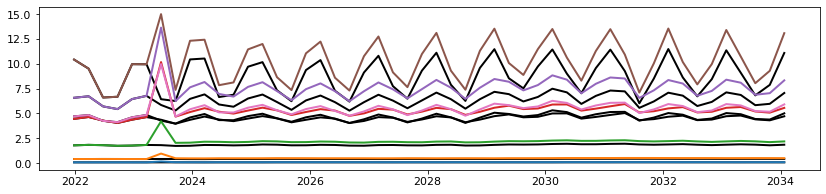

In [250]:
# Temperature at all depths - heatwave_01
fig, ax = plt.subplots(figsize = (14,3))
ax.tick_params(labelsize=label_size)

Temp_control = np.ma.filled(control.Temp[start:end,ocean_boxes,:], np.nan)
t_control = Temp_control.mean(axis=1)
t_control = Temp_control.mean(axis=1)

Temp_heatwave = np.ma.filled(heatwave.Temp[start:end,ocean_boxes,:], np.nan)
t_heatwave = Temp_heatwave.mean(axis=1)
t_heatwave = Temp_heatwave.mean(axis=1)

ax.plot(time, t_control, 'k', linewidth = 2);
ax.plot(time, t_heatwave, linewidth = 2);

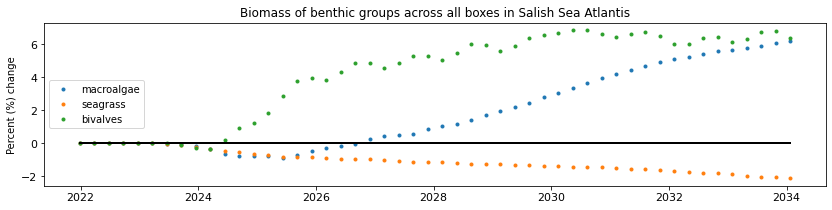

In [160]:
plot_benthic_box(species_of_interest, heatwave, 63)

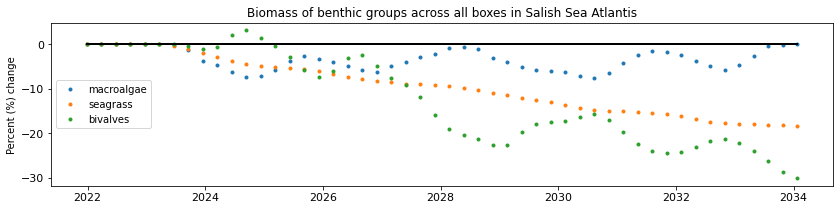

In [161]:
plot_benthic_box(species_of_interest, heatwave, 66)

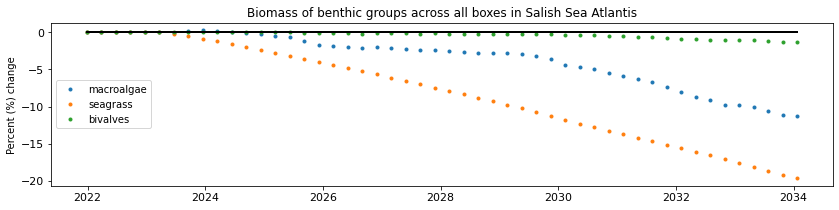

In [142]:
plot_benthic_box(species_of_interest, heatwave, 83)

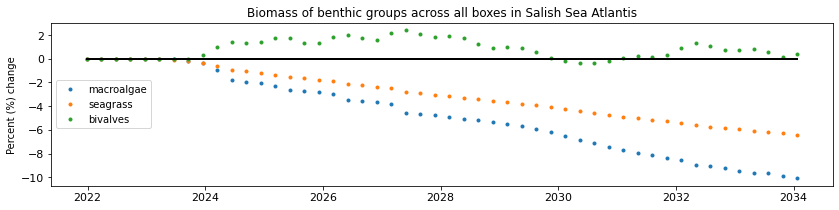

In [143]:
plot_benthic_box(species_of_interest, heatwave, 96)

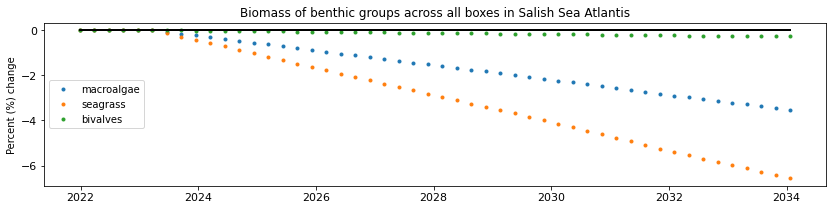

In [144]:
plot_benthic_box(species_of_interest, heatwave, 102)

In [130]:
t[10]

numpy.datetime64('2024-06-14T14:00:00.000000000')

In [23]:
str(t[18])

'2026-06-04T14:00:00.000000000'

In [24]:
# to date 2028-05-24T14:00:00.000000000 - 5 years(26), 2026-06-04T14:00:00.000000000 - 3 years(18), 2024-06-14T14:00:00.000000000 - 1 year(10)

boxes = [63, 66, 83, 96, 102]
years = [10, 18, 26]
locations = ['Trincomali Channel','Saanich Inlet','Sunshine coast','Hornby & Denman Islands','Cape Lazo']
bio_colours = ['#906D43','#4CA532','#145E1C']
#box colours '#3A7396'
heat_dataAggregate = pd.DataFrame({'Bivalves': [],
                    'Macroalgae': [],
                    'Seagrass': []},)

for box in boxes:
    for year in years:
        macroalgae1 = np.ma.filled(climate.variables['Macroalgae_N'][year,box], np.nan)
        m_control = np.ma.filled(control.variables['Macroalgae_N'][year,box], np.nan)
        seagrass1 = np.ma.filled(climate.variables['Seagrass_N'][year,box], np.nan)
        s_control = np.ma.filled(control.variables['Seagrass_N'][year,box], np.nan)
        bivalves1 = np.ma.filled(climate.variables['Bivalves_N'][year,box], np.nan)
        b_control = np.ma.filled(control.variables['Bivalves_N'][year,box], np.nan)

        macroalgae = (macroalgae1/m_control-1)*100
        seagrass = (seagrass1/s_control-1)*100
        bivalves = (bivalves1/b_control-1)*100

        bio_groups = ['Bivalves','Macroalgae','Seagrass',]
        results = [bivalves,macroalgae,seagrass]

        heat_dataAggregate.loc[len(heat_dataAggregate.index)] = [bivalves,macroalgae,seagrass]

heat_dataAggregate.shape

(15, 3)

In [25]:
data_indices = ['Trincomali Channel', '', '', 'Saanich Inlet','','', 'Sunshine coast','','','Hornby & Denman Islands','','','Cape Lazo','','',]
heat_dataAggregate.index = data_indices

In [26]:
heat_dataAggregate

,Bivalves,Macroalgae,Seagrass
Trincomali Channel,0.030169,-0.033857,-0.026552
,0.123920,-0.277339,-0.164454
,0.240841,-0.796452,-0.424058
Saanich Inlet,-0.208127,-0.375359,-0.211401
,0.090707,-2.186542,-1.119375
,-1.072612,-5.748847,-2.728366
Sunshine coast,-0.003304,-0.041207,-0.077410
,0.246495,1.595001,-0.548868
,0.787068,5.243286,-1.642776
Hornby & Denman Islands,0.086361,-0.163956,-0.067867


In [27]:
heat_dataAggregate.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/climate_01/heat2_data_aggregate.csv")

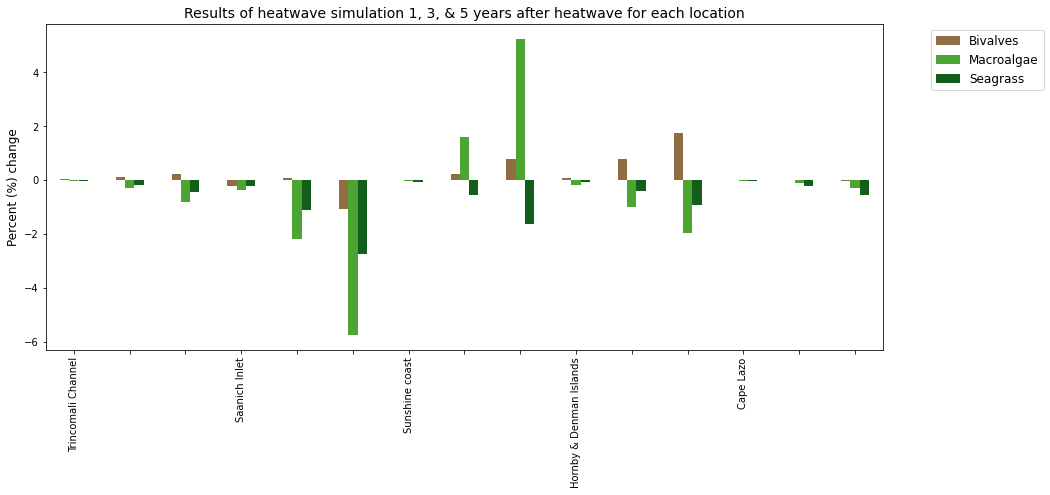

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
heat_dataAggregate.plot.bar(ax=ax, color=bio_colours)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # to place the legend outside
plt.ylabel('Percent (%) change', fontsize=12)
plt.title('Results of heatwave simulation 1, 3, & 5 years after heatwave for each location', fontsize=14);

## climate change

In [253]:
#If different time scale neeeded
start = 0
end = t.size-1

time = t[start:end]

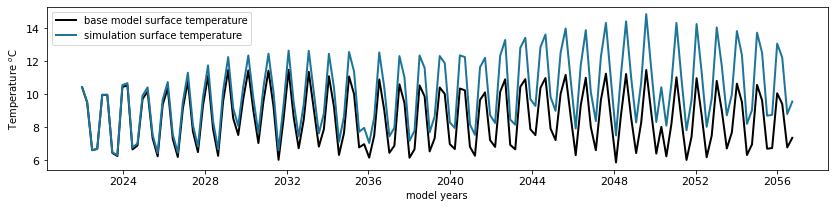

In [21]:
# Temperature at all depths - climate_01
fig, ax = plt.subplots(figsize = (14,3))
ax.tick_params(labelsize=label_size)

Temp_control = np.ma.filled(control.Temp[start:end,ocean_boxes,5], np.nan)
t_control = Temp_control.mean(axis=1)
#t_control = t_control.mean(axis=1)

Temp_climate = np.ma.filled(climate.Temp[start:end,ocean_boxes,5], np.nan)
t_climate = Temp_climate.mean(axis=1)
#t_climate = t_climate.mean(axis=1)

ax.plot(time, t_control, 'k', linewidth = 2);
ax.plot(time, t_climate, '#1e759a',linewidth = 2);
ax.legend(['base model surface temperature','simulation surface temperature'])
ax.set_ylabel('Temperature $^{o}$C');
ax.set_xlabel('model years');
ax.tick_params(labelsize=label_size)

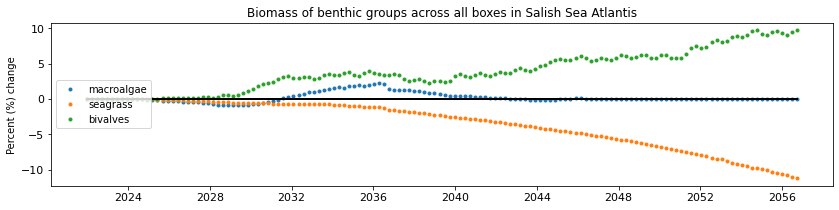

In [38]:
plot_benthic_box(species_of_interest, climate, 63) #Trincomali Channel

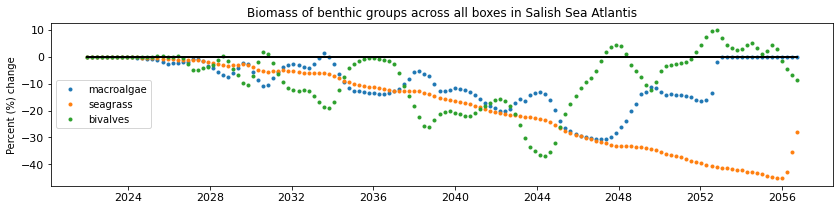

In [31]:
plot_benthic_box(species_of_interest, climate, 66) # Saanich Inlet

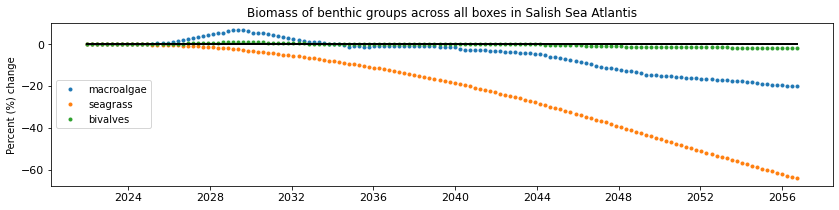

In [32]:
plot_benthic_box(species_of_interest, climate, 83) # Sunshine coast

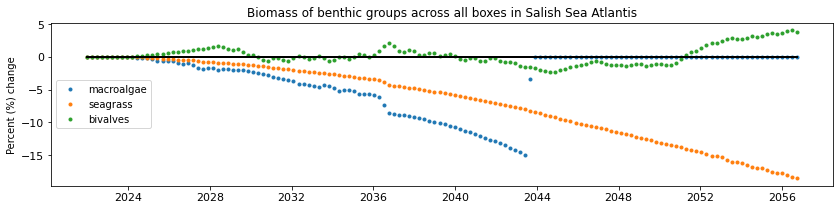

In [33]:
plot_benthic_box(species_of_interest, climate, 96) # Hornby & Denman Islands

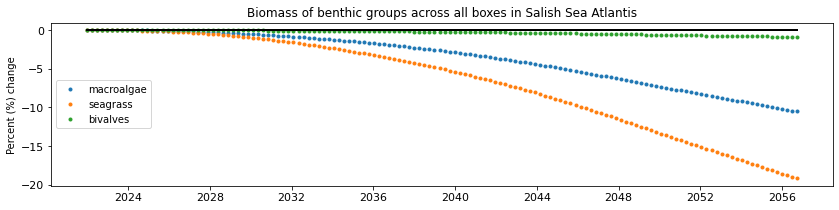

In [34]:
plot_benthic_box(species_of_interest, climate, 102) # Cape Lazo

In [58]:
t[128]

numpy.datetime64('2053-07-12T14:00:00.000000000')

In [ ]:
boxes = [63, 66, 83, 96, 102]
years = [47, 87, 128]
locations = ['Trincomali Channel','Saanich Inlet','Sunshine coast','Hornby & Denman Islands','Cape Lazo']
bio_colours = ['#906D43','#4CA532','#145E1C']
#box colours '#3A7396'

fig, ax = plt.subplots(figsize = (14,9))

In [92]:
len(boxes)

5

In [ ]:
# to date 2033-07-27T14:00:00.000000000 - 10 years ahead (47)
# to date 2043-06-05T14:00:00.000000000 - 20 years ahead (87)
# to date 2053-07-12T14:00:00.000000000 - 30 years ahead (128)

boxes = [63, 66, 83, 96, 102]
years = [47, 87, 128]
elapsed_time = [10, 20, 30]
locations = ['Trincomali Channel','Saanich Inlet','Sunshine coast','Hornby & Denman Islands','Cape Lazo']
bio_colours = ['#906D43','#4CA532','#145E1C']
#box colours '#3A7396'
dataAggregate = pd.DataFrame({'Bivalves': [],
                    'Macroalgae': [],
                    'Seagrass': []},)
size = len(boxes)*len(years)

for box in boxes:
    for year in years:
        macroalgae1 = np.ma.filled(climate.variables['Macroalgae_N'][year,box], np.nan)
        m_control = np.ma.filled(control.variables['Macroalgae_N'][year,box], np.nan)
        seagrass1 = np.ma.filled(climate.variables['Seagrass_N'][year,box], np.nan)
        s_control = np.ma.filled(control.variables['Seagrass_N'][year,box], np.nan)
        bivalves1 = np.ma.filled(climate.variables['Bivalves_N'][year,box], np.nan)
        b_control = np.ma.filled(control.variables['Bivalves_N'][year,box], np.nan)

        macroalgae = (macroalgae1/m_control-1)*100
        seagrass = (seagrass1/s_control-1)*100
        bivalves = (bivalves1/b_control-1)*100

        bio_groups = ['Bivalves','Macroalgae','Seagrass',]
        results = [bivalves,macroalgae,seagrass]
        print(year, box)

        dataAggregate.loc[len(dataAggregate.index)] = [bivalves,macroalgae,seagrass]

dataAggregate.shape


In [117]:
data_indices = ['Trincomali Channel', '', '', 'Saanich Inlet','','', 'Sunshine coast','','','Hornby & Denman Islands','','','Cape Lazo','','',]
dataAggregate.index = data_indices

In [118]:
dataAggregate

,Bivalves,Macroalgae,Seagrass
Trincomali Channel,3.410421,1.271549,-0.764231
,4.097844,-0.018757,-3.755857
,8.736682,0.000000,-8.993366
Saanich Inlet,-18.655201,1.182265,-6.086792
,-30.266872,-16.273863,-22.261926
,3.142349,0.000000,-41.617856
Sunshine coast,0.215368,0.476825,-7.514599
,-0.085962,-4.165405,-26.575190
,-1.599080,-17.469389,-55.390003
Hornby & Denman Islands,-0.160723,-4.324396,-2.451838


In [147]:
dataAggregate.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/LivingLabs/climate_01/data_aggregate.csv")

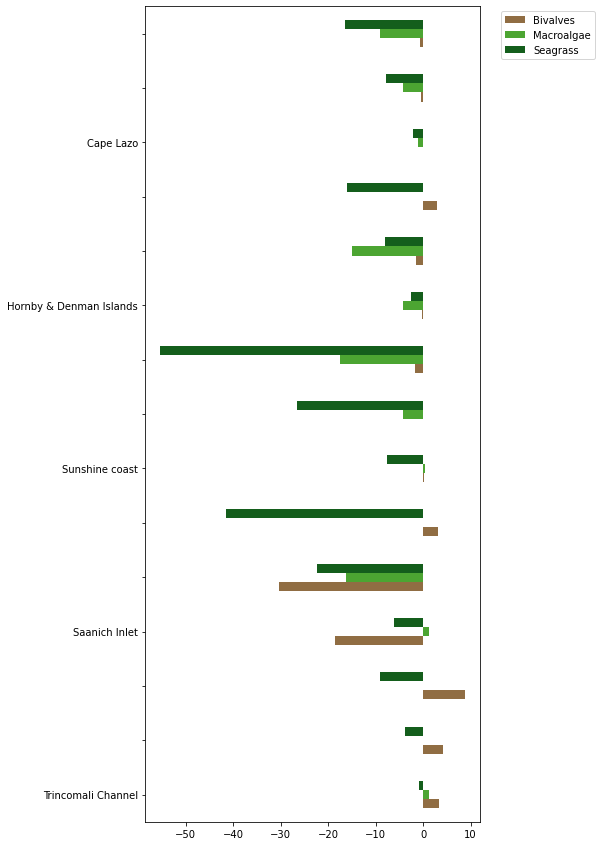

In [254]:
fig, ax = plt.subplots(figsize=(6, 15))
dataAggregate.plot.barh(ax=ax, color=bio_colours)  # ax=ax lets the dataframe plot use the subplot axes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');  # place the legend outside

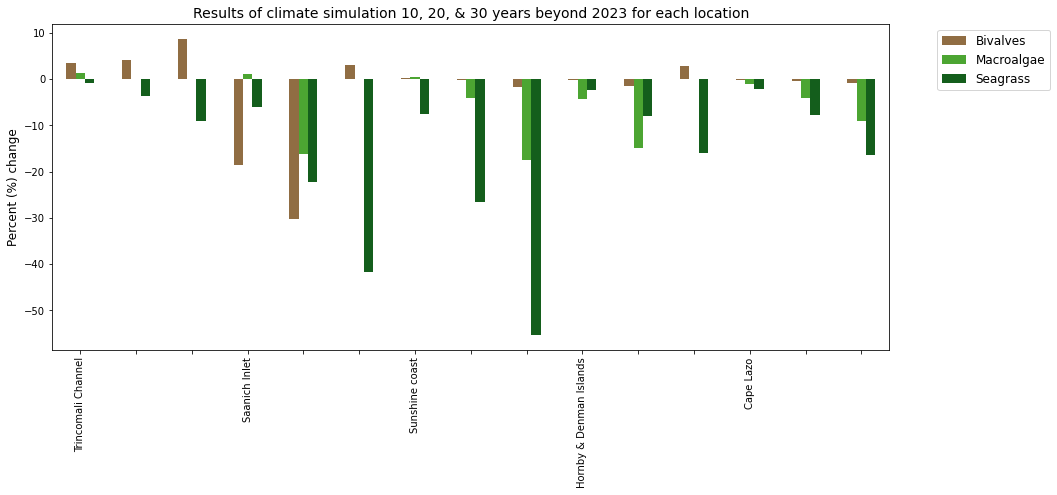

In [155]:
fig, ax = plt.subplots(figsize=(15, 6))
dataAggregate.plot.bar(ax=ax, color=bio_colours)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # to place the legend outside
plt.ylabel('Percent (%) change', fontsize=12)
plt.title('Results of climate simulation 10, 20, & 30 years beyond 2023 for each location', fontsize=14);

In [ ]:
# Across whole
years = [47, 87, 128]
elapsed_time = [10, 20, 30]
locations = ['Trincomali Channel','Saanich Inlet','Sunshine coast','Hornby & Denman Islands','Cape Lazo']
bio_colours = ['#906D43','#4CA532','#145E1C']
#box colours '#3A7396'
dataAggregate = pd.DataFrame({'Bivalves': [],
                    'Macroalgae': [],
                    'Seagrass': []},)
size = len(boxes)*len(years)

for box in boxes:
    for year in years:
        macroalgae1 = np.ma.filled(climate.variables['Macroalgae_N'][year,box], np.nan)
        m_control = np.ma.filled(control.variables['Macroalgae_N'][year,box], np.nan)
        seagrass1 = np.ma.filled(climate.variables['Seagrass_N'][year,box], np.nan)
        s_control = np.ma.filled(control.variables['Seagrass_N'][year,box], np.nan)
        bivalves1 = np.ma.filled(climate.variables['Bivalves_N'][year,box], np.nan)
        b_control = np.ma.filled(control.variables['Bivalves_N'][year,box], np.nan)

        macroalgae = (macroalgae1/m_control-1)*100
        seagrass = (seagrass1/s_control-1)*100
        bivalves = (bivalves1/b_control-1)*100

        bio_groups = ['Bivalves','Macroalgae','Seagrass',]
        results = [bivalves,macroalgae,seagrass]
        print(year, box)

        dataAggregate.loc[len(dataAggregate.index)] = [bivalves,macroalgae,seagrass]

dataAggregate.shape